<a href="https://colab.research.google.com/github/sechmo/IA-minirobots-2023-II/blob/master/5.%20Redes%20Neuronales/2.%20Fruitmeter/fruitmeter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A little fruitmeter**

In this notebook we are goint to train a simple neural network to recognize and differentiate between 4 different kinds of fruits (apples, pears, strawberries and banananas) using Pytorch.



## Preamble

Enable data loading depending on your development environment, this notebook was originally created in google colab using google drive and the kaggle api

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
KEY_PATH = "/path/to/your/kaggle.json"

In [3]:
! pip install kaggle --quiet
! mkdir ~/.kaggle
! cp '{KEY_PATH}' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d moltean/fruits

100% 1.28G/1.28G [00:38<00:00, 36.0MB/s]
100% 1.28G/1.28G [00:38<00:00, 35.9MB/s]


In [15]:
BASE_DIR = './data'
DATA_DIR = BASE_DIR + '/fruits-360_dataset/fruits-360'

In [5]:
! mkdir '{BASE_DIR}'
! unzip "fruits.zip" -d "data" fruits-360_dataset/fruits-360/{Test,Training}/{Apple,Banana,Pear,Strawberry}\*

We are going to import the necessary pytorch and other utilities

In [7]:
from torch.utils.data import DataLoader, Dataset

import torch
import torchvision.transforms.v2.functional as F
import torchvision.transforms.v2 as T
import torch.nn as nn
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt

import os
import shutil

Check Pytorch version

In [8]:
torch.__version__

'2.1.0+cu118'

Check which kind of device is available to train the neural network

In [9]:

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## The data
The dataset includes more than 100 kinds of fruits among which we find different kinds of apples, but we do no want to differentiate between those, so we created a custom dataset to relabel and only load the appropiate data given a list of prefixes (e.g. `['apple', 'banana']`). We also apply transforms to the images and preload them in the device (ideally a gpu or tensor processor) so training is faster.

In [11]:
class PrefixClassifiedDataset(tv.datasets.VisionDataset):
    def __init__(self, root: str, prefixes: list[str], transform):
        super().__init__(root=root, transform=transform)
        self.prefixes = prefixes
        self.find_classes()
        self.preload()

    def pil_loader(self, path: str):
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")

    def __getitem__(self, index: int):
        sample, target = self.preloaded_samples[index]

        return sample, target

    def __len__(self) -> int:
        return len(self.preloaded_samples)

    def preload(self):

        print("Preloading to device: ", device)
        i = 0
        self.preloaded_samples = []
        for path,target in self.samples:
            sample = self.pil_loader(path)
            if self.transform is not None:
              sample = self.transform(sample)

            sample = sample.to(device)
            target = torch.tensor(target).to(device)
            self.preloaded_samples.append((sample,target))
            i += 1
            if i % 1000 == 0:
              print(f"loaded {i} samples")

        print("Finished preload")

    def find_classes(self):

        print("Finding classes")
        base_classes_paths = {}
        selected_classes = {}
        class_to_idx = {}
        classes = []

        for i,pre in enumerate(self.prefixes):
            selected_classes[pre] = list()
            class_to_idx[pre] = i
            classes.append(pre)

        for d in os.listdir(self.root):
            path = os.path.join(self.root,d)
            if os.path.isdir(path):
                base_classes_paths[d] = path

            for pre in self.prefixes:
                if d.startswith(pre):
                    selected_classes[pre].append(d)

        for pre,sel_cls in selected_classes.items():
            if len(sel_cls) == 0:
                raise Exception(f"No class found for prefix {pre}")


        samples = []
        for pre,original_classes in selected_classes.items():
            for or_cls in original_classes:
                cls_path = base_classes_paths[or_cls]
                for image in os.listdir(cls_path):
                    image_path = os.path.join(cls_path,image)
                    if os.path.isfile(image_path):
                        samples.append((image_path, class_to_idx[pre]))

        self.class_to_idx = class_to_idx
        self.samples = samples
        self.selected_classes = selected_classes
        self.classes = classes
        print("Found classes: ", self.classes)



We choose the previously mentioned kinds of fruits as prefixes

In [12]:
fruit_prefixes = ['Apple','Banana', 'Strawberry', 'Pear']

The dataset images have been already resized to 100x100 pixels, but we can train the network with way less resolution, so we are going to resize the images to 28 by 28.

In [13]:
transform = T.Compose([T.ToImage(),T.ConvertImageDtype(), T.Resize((28,28), antialias=True)])

As we are preloading the data into the device, this might take some time, but it will save us a lot of time in training. Remember we need training and testing data.

In [16]:
train_dataset = PrefixClassifiedDataset(
    root=f'{DATA_DIR}/Training',
    transform=transform,
    prefixes= fruit_prefixes
)

test_dataset = PrefixClassifiedDataset(
    root=f'{DATA_DIR}/Test',
    transform=transform,
    prefixes= fruit_prefixes
)


Finding classes
Found classes:  ['Apple', 'Banana', 'Strawberry', 'Pear']
Preloading to device:  cuda
loaded 1000 samples
loaded 2000 samples
loaded 3000 samples
loaded 4000 samples
loaded 5000 samples
loaded 6000 samples
loaded 7000 samples
loaded 8000 samples
loaded 9000 samples
loaded 10000 samples
loaded 11000 samples
loaded 12000 samples
loaded 13000 samples
loaded 14000 samples
Finished preload
Finding classes
Found classes:  ['Apple', 'Banana', 'Strawberry', 'Pear']
Preloading to device:  cuda
loaded 1000 samples
loaded 2000 samples
loaded 3000 samples
loaded 4000 samples
Finished preload


We create the dataloaders that will randomly dispatch the data in batches for training

In [18]:
# set as you please
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

To help us visualize the data we create some helper functions to display images and labels.

In [19]:
def show_img(ax,img,label):
    img = img.detach()
    img = F.to_pil_image(img)
    ax.imshow(img)
    ax.set(
        xticklabels=[],
        yticklabels=[],
        xticks=[],
        yticks=[]
    )
    ax.set_axis_off()
    ax.set_title(label, fontsize=7)

In [20]:
def show(images,labels,cols=8):
    n = len(images)
    rows = n // cols
    fig, ax = plt.subplots(rows,cols, figsize=(0.5*cols, 0.6*rows))
    for i,img in enumerate(images):
        show_img(ax[i//cols,i%cols],images[i],labels[i])
    fig.tight_layout()

Here we can see some sample training data, as we can see it encompasses photos from all angles of the fruits

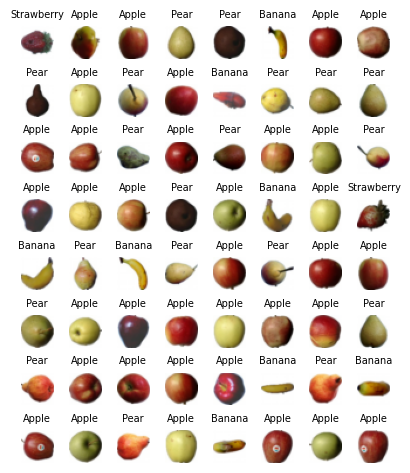

In [21]:
images, encoded_labels = next(iter(train_dataloader))
labels = [train_dataset.classes[l.item()] for l in encoded_labels]

show(images,labels)

## Training and testing Routines
The train and test routines based on the pytorch tutorial, in the former we pass forward the data and the optimize backward, in the later we just pass forward and omit back propagation, just comparing against expected results

In [27]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct,test_loss

## The network

After some trial and error we ended up with a very simple yet effective network, it just has one hidden layer, and input and output layers, we are using a ReLU and a Tanh as activation functions

In [41]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28 * 3, 28*28),
            nn.ReLU(),
            nn.Linear(28*28, 28*28),
            nn.Tanh(),
            nn.Linear(28*28, len(train_dataset.classes))
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2352, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=784, bias=True)
    (3): Tanh()
    (4): Linear(in_features=784, out_features=4, bias=True)
  )
)


## Hyperparameters

Here we choose the learning rate and the number of training epochs, the 1e-2 learning rate was particularly efficient compared with traditional lower rates

In [42]:
learning_rate = 1e-2
epochs = 20

## Optimization and Loss


We are going to use stochastic gradient descent as our optimization method

**NOTE:** Remember to rerun the cell below if you changed the model

In [43]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

As this is a classification problem we are going to use the cross entropy loss function for error quantization

In [44]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

## Training

We run the training and testing routing for each epoch and save the test results.

In [45]:
accuracies = []
losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    acc, loss = test(test_dataloader, model, loss_fn)
    accuracies.append(acc)
    losses.append(loss)
print("Done!")

Epoch 1
-------------------------------
loss: 1.442261  [   64/14101]
loss: 0.539006  [ 6464/14101]
loss: 0.478627  [12864/14101]
Test Error: 
 Accuracy: 69.8%, Avg loss: 0.737782 

Epoch 2
-------------------------------
loss: 0.452343  [   64/14101]
loss: 0.379137  [ 6464/14101]
loss: 0.393576  [12864/14101]
Test Error: 
 Accuracy: 72.3%, Avg loss: 0.724843 

Epoch 3
-------------------------------
loss: 0.469973  [   64/14101]
loss: 0.303906  [ 6464/14101]
loss: 0.290003  [12864/14101]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.584532 

Epoch 4
-------------------------------
loss: 0.307758  [   64/14101]
loss: 0.307164  [ 6464/14101]
loss: 0.263414  [12864/14101]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.503021 

Epoch 5
-------------------------------
loss: 0.412100  [   64/14101]
loss: 0.406155  [ 6464/14101]
loss: 0.198730  [12864/14101]
Test Error: 
 Accuracy: 79.9%, Avg loss: 0.486210 

Epoch 6
-------------------------------
loss: 0.250061  [   64/14101]
loss: 0.246845  [ 64

## Results

Here we can see some predictions and wheter they are right or not, and what was predicted then.

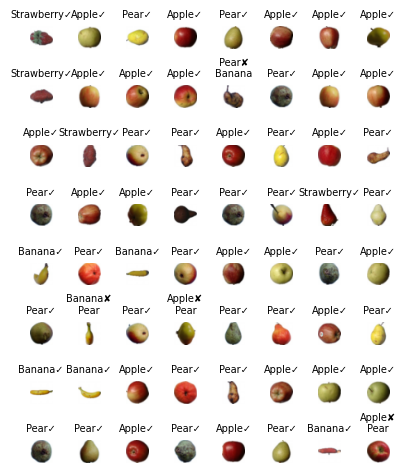

In [46]:
images, encoded_labels = next(iter(test_dataloader))

with torch.no_grad():
    pred = model(images)
    labels = []
    for real, predicted in zip(encoded_labels, pred.argmax(1)):
      real_label = train_dataset.classes[real.item()]
      predicted_label = train_dataset.classes[predicted.item()]
      if real.item() == predicted.item():
        label = f'{real_label}✓'
      else:
        label = f'{real_label}✘\n{predicted_label}'

      labels.append(label)

show(images,labels)

We can see how it sometimes mistakes pear and apples, as well as banans and pears, this last case is usually when the fruit if front facing

Text(0.5, 1.0, 'Acurracy vs Epoch')

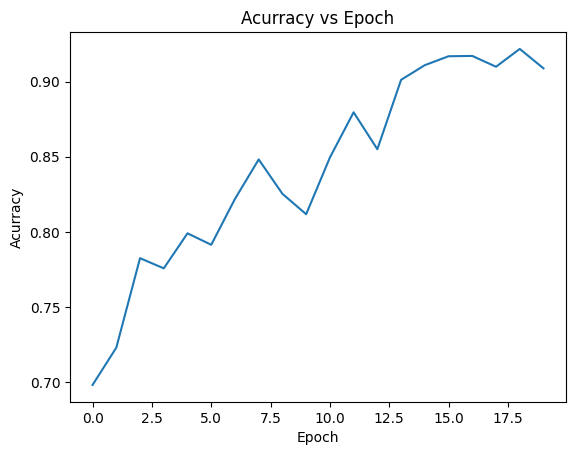

In [47]:
plt.plot(accuracies)
plt.xlabel("Epoch")
plt.ylabel("Acurracy")
plt.title("Acurracy vs Epoch")


Acurracy doesn't usually go above 92%, but it learns relatively fast, after 15 epochs it usually learns as much as it can

Text(0.5, 1.0, 'Loss vs Epoch')

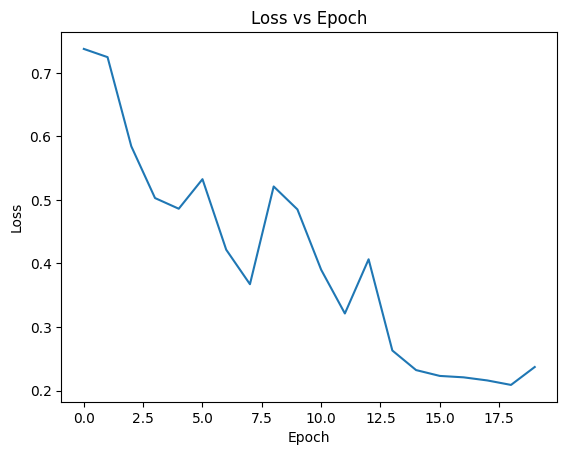

In [48]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")

Loss also goes down with the epochs, but it is notable that sometimes altought loss goes down, accuracy doesn't improve, many of the tested architectures overfit and stagnate around 85% acurracy

It is also remarkable how fast the neural network can learn (usually less than half a second per epoch), this is mostly due to how the image data was handled, the downscaling not only allows the model manage quadratically less parameters, but also allows us to preload the tensors into the GPU device ram, taking full advantage of the colab T4 GPU runtime.

To conclude, we learned to use pytorch and torchvision, we achieved a resonable acurracy rate with our model that has reasonable confussion with some fruits, doing this we demonstrate the effectiveness of neural networks and its ease of use for image data